In [1]:
from copy import copy
import os
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

In [2]:
pattern_date = '2023-12-24'
root_dir = f'{"/".join(os.getcwd().split("/")[:-1])}'
format_anno_dir = f'{root_dir}/data/outputs/01.format_and_cv'
pose_output_dir = f'{root_dir}/data/outputs/02.pose_estimation'

In [3]:
annotation_df = pd.read_csv(f'{format_anno_dir}/annotation-{pattern_date}.csv')

In [4]:
person_head_detection_df = pd.read_csv(f'{pose_output_dir}/pred-{pattern_date}.csv')

In [5]:
display(annotation_df.head())
display(person_head_detection_df.head())

,unique_key,relative_img_path,label,left,top,right,bottom,validation
0,for-learning/helmet-on-head/IMAG0006,for-learning/helmet-on-head/IMAG0006.JPG,helmet,2917.367124,1435.063828,3629.453867,2142.732403,0
1,for-learning/helmet-on-head/IMAG0006,for-learning/helmet-on-head/IMAG0006.JPG,safety belt,2867.396125,2121.918622,3741.888616,3970.182430,0
2,for-learning/helmet-on-head/IMAG0006,for-learning/helmet-on-head/IMAG0006.JPG,person,2979.830874,1426.738316,3725.231616,3982.670699,0
3,for-learning/helmet-on-head/IMAG0007,for-learning/helmet-on-head/IMAG0007.JPG,helmet unknown (occlusion),2950.889128,1413.968436,3627.642626,2066.100430,0
4,for-learning/helmet-on-head/IMAG0007,for-learning/helmet-on-head/IMAG0007.JPG,safety belt,2999.664155,2084.384505,3755.677072,4150.484935,0


,unique_key,pred,left,top,right,bottom,relative_img_path,validation
0,for-learning/helmet-on-head/IMAG0006,person,2859.099121,1443.542114,3729.670410,4163.889648,for-learning/helmet-on-head/IMAG0006.JPG,0
1,for-learning/helmet-on-head/IMAG0006,head,2637.946690,1232.082603,3799.397353,2393.533266,for-learning/helmet-on-head/IMAG0006.JPG,0
2,for-learning/helmet-on-head/IMAG0007,person,2732.054932,1410.219360,3758.433594,4166.869629,for-learning/helmet-on-head/IMAG0007.JPG,0
3,for-learning/helmet-on-head/IMAG0007,head,2616.856355,1221.980232,3760.566203,2365.690080,for-learning/helmet-on-head/IMAG0007.JPG,0
4,for-learning/helmet-on-head/IMAG0009,person,2820.086914,1406.403564,3842.369873,4167.707031,for-learning/helmet-on-head/IMAG0009.JPG,0


## 評価方法

In [6]:
def calculate_intersection_per_label(pred_bbox, label_bbox):
    # バウンディングボックスの座標情報を取得
    x1_1, y1_1, x2_1, y2_1 = label_bbox
    x1_2, y1_2, x2_2, y2_2 = pred_bbox

    # 交差する領域を計算
    x_intersection = max(0, min(x2_1, x2_2) - max(x1_1, x1_2))
    y_intersection = max(0, min(y2_1, y2_2) - max(y1_1, y1_2))
    intersection_area = x_intersection * y_intersection

    # 正解ラベルの面積
    area_label_bbox = (x2_1 - x1_1) * (y2_1 - y1_1)

    # 交差する領域の面積 / 正解ラベルの面積
    return intersection_area / area_label_bbox

In [7]:
def calculate_iou(box1, box2):
    # バウンディングボックスの座標情報を取得
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # 交差する領域を計算
    intersection_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    # 交差領域の面積と各バウンディングボックスの面積を計算
    intersection_area = intersection_x * intersection_y
    box1_area = w1 * h1
    box2_area = w2 * h2

    # IoUを計算
    iou = intersection_area / (box1_area + box2_area - intersection_area)

    return iou

In [8]:
def calculate_precision(ground_truth_df, predicted_df, ratio_threshold=0.9, iou_threshold=0.3):
    TP_list = [False for _ in range(len(predicted_df))]
    for i, pred_box in enumerate(predicted_df.values):
        for gt_box in ground_truth_df.values:
            if pd.isna(pred_box[1]) and pd.isna(gt_box[2]):
                TP_list[i] = True
                break
            if pred_box[1] == 'person' and gt_box[2] in ['person', 'person in high place']:
                if (
                    calculate_intersection_per_label(pred_box[2:6], gt_box[3:7]) >= ratio_threshold
                ) and (
                    calculate_iou(pred_box[2:6], gt_box[3:7]) >= iou_threshold
                ):
                    TP_list[i] = True
                    break
            if pred_box[1] == 'head' and gt_box[2] in [
                'helmet', 'helmet unknown (occlusion)', 'no-helmet',
                'unsafe-helmet (no chin strap)', 'helmet unknown (small)', 'unsafe-helmet (inadequate covering)']:
                if (
                    calculate_intersection_per_label(pred_box[2:6], gt_box[3:7]) >= ratio_threshold
                ) and (
                    calculate_iou(pred_box[2:6], gt_box[3:7]) >= iou_threshold
                ):
                    TP_list[i] = True
                    break
    return TP_list

In [9]:
def calculate_recall(ground_truth_df, predicted_df, ratio_threshold=0.9, iou_threshold=0.3):
    TP_list = [False for _ in range(len(ground_truth_df))]
    for i, gt_box in enumerate(ground_truth_df.values):
        if len(predicted_df.values) == 0 and pd.isna(gt_box[2]):
            TP_list[i] = True
            continue
        for pred_box in predicted_df.values:
            if pd.isna(pred_box[1]) and pd.isna(gt_box[2]):
                TP_list[i] = True
                break
            if pred_box[1] == 'person' and gt_box[2] in ['person', 'person in high place']:
                if (
                    calculate_intersection_per_label(pred_box[2:6], gt_box[3:7]) >= ratio_threshold
                ) and (
                    calculate_iou(pred_box[2:6], gt_box[3:7]) >= iou_threshold
                ):
                    TP_list[i] = True
                    break
            if pred_box[1] == 'head' and gt_box[2] in [
                'helmet', 'helmet unknown (occlusion)', 'no-helmet',
                'unsafe-helmet (no chin strap)', 'helmet unknown (small)', 'unsafe-helmet (inadequate covering)']:
                if (
                    calculate_intersection_per_label(pred_box[2:6], gt_box[3:7]) >= ratio_threshold
                ) and (
                    calculate_iou(pred_box[2:6], gt_box[3:7]) >= iou_threshold
                ):
                    TP_list[i] = True
                    break
    return TP_list

## 評価実施

In [10]:
unique_key = annotation_df['unique_key'].unique()

# 人検出
person_anno = annotation_df[
    (annotation_df['label'] == 'person') |
    (annotation_df['label'] == 'person in high place') |
    (annotation_df['label'].isnull())
]

person_result = person_head_detection_df[person_head_detection_df['pred'] == 'person']

annotation_add_pred_list = []
person_head_detection_add_pred_list = []

for key in unique_key:
    anno_per_img_df = copy(person_anno[person_anno['unique_key'] == key])
    result_per_img_df = copy(person_result[person_result['unique_key'] == key])

    anno_per_img_df['TP'] = calculate_recall(
        anno_per_img_df, result_per_img_df, ratio_threshold=0.8)
    result_per_img_df['TP'] = calculate_precision(
        anno_per_img_df, result_per_img_df, ratio_threshold=0.8)
    annotation_add_pred_list.append(anno_per_img_df)
    person_head_detection_add_pred_list.append(result_per_img_df)

annotation_person_add_pred_df = pd.concat(annotation_add_pred_list)
person_head_detection_person_add_pred_df = pd.concat(person_head_detection_add_pred_list)

# 頭部検出
head_anno = annotation_df[
    (annotation_df['label'] == 'unsafe-helmet (inadequate covering)') |
    (annotation_df['label'] == 'helmet unknown (occlusion)') |
    (annotation_df['label'] == 'unsafe-helmet (no chin strap)') |
    (annotation_df['label'] == 'no-helmet') |
    (annotation_df['label'] == 'helmet') |
    (annotation_df['label'] == 'helmet unknown (small)') |
    (annotation_df['label'].isnull())
]

head_result = person_head_detection_df[person_head_detection_df['pred'] == 'head']

annotation_add_pred_list = []
person_head_detection_add_pred_list = []

for key in unique_key:
    anno_per_img_df = copy(head_anno[head_anno['unique_key'] == key])
    result_per_img_df = copy(head_result[head_result['unique_key'] == key])

    anno_per_img_df['TP'] = calculate_recall(
        anno_per_img_df, result_per_img_df, ratio_threshold=0.9)
    result_per_img_df['TP'] = calculate_precision(
        anno_per_img_df, result_per_img_df, ratio_threshold=0.9)
    annotation_add_pred_list.append(anno_per_img_df)
    person_head_detection_add_pred_list.append(result_per_img_df)

annotation_head_add_pred_df = pd.concat(annotation_add_pred_list)
person_head_detection_head_add_pred_df = pd.concat(person_head_detection_add_pred_list)

## 学習データで評価

In [11]:
# 頭部検出
training_annotation_head_add_pred_df = annotation_head_add_pred_df[(
    (annotation_head_add_pred_df['unique_key'].str.contains('fixed-point-camera')) |
    (annotation_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
    (annotation_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
)]
training_person_head_detection_head_add_pred_df = person_head_detection_head_add_pred_df[(
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('fixed-point-camera')) |
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
)]

head_TP_precision = training_person_head_detection_head_add_pred_df.TP.value_counts()[True]
head_TP_recall = training_annotation_head_add_pred_df.TP.value_counts()[True]
head_FP = len(training_person_head_detection_head_add_pred_df) - head_TP_precision
head_FN = len(training_annotation_head_add_pred_df) - head_TP_recall

print('頭部検出')
print(f'precision: {head_TP_recall / (head_TP_recall + head_FP)} [correct:{head_TP_recall} / incorrect:{head_FP}]')
print(f'recall: {head_TP_recall / (head_TP_recall + head_FN)} [correct:{head_TP_recall} / incorrect:{head_FN}]')

# 人検出
training_annotation_person_add_pred_df = annotation_person_add_pred_df[(
    (annotation_person_add_pred_df['unique_key'].str.contains('fixed-point-camera')) |
    (annotation_person_add_pred_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
    (annotation_person_add_pred_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
)]
training_person_head_detection_head_add_pred_df = person_head_detection_head_add_pred_df[(
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('fixed-point-camera')) |
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
)]

person_TP_precision = training_person_head_detection_head_add_pred_df.TP.value_counts()[True]
person_TP_recall = training_annotation_person_add_pred_df.TP.value_counts()[True]
person_FP = len(training_person_head_detection_head_add_pred_df) - person_TP_precision
person_FN = len(training_annotation_person_add_pred_df) - person_TP_recall

print('人検出')
print(f'precision: {person_TP_recall / (person_TP_recall + person_FP)} [correct:{person_TP_recall} / incorrect:{person_FP}]')
print(f'recall: {person_TP_recall / (person_TP_recall + person_FN)} [correct:{person_TP_recall} / incorrect:{person_FN}]')

頭部検出
precision: 0.8781107160995429 [correct:1729 / incorrect:240]
recall: 0.8405444822557122 [correct:1729 / incorrect:328]
人検出
precision: 0.8806563898557931 [correct:1771 / incorrect:240]
recall: 0.8597087378640776 [correct:1771 / incorrect:289]


## 評価データで評価

In [12]:
# 頭部検出
eval_annotation_head_add_pred_df = annotation_head_add_pred_df[(
    (annotation_head_add_pred_df['unique_key'].str.contains('evaluation'))
)]
eval_person_head_detection_head_add_pred_df = person_head_detection_head_add_pred_df[(
    (person_head_detection_head_add_pred_df['unique_key'].str.contains('evaluation'))
)]

head_TP_precision = eval_person_head_detection_head_add_pred_df.TP.value_counts()[True]
head_TP_recall = eval_annotation_head_add_pred_df.TP.value_counts()[True]
head_FP = len(eval_person_head_detection_head_add_pred_df) - head_TP_precision
head_FN = len(eval_annotation_head_add_pred_df) - head_TP_recall

print('頭部検出')
print(f'precision: {head_TP_recall / (head_TP_recall + head_FP)} [correct:{head_TP_recall} / incorrect:{head_FP}]')
print(f'recall: {head_TP_recall / (head_TP_recall + head_FN)} [correct:{head_TP_recall} / incorrect:{head_FN}]')

# 人検出
eval_annotation_person_add_pred_df = annotation_person_add_pred_df[(
    (annotation_person_add_pred_df['unique_key'].str.contains('evaluation'))
)]
eval_person_head_detection_person_add_pred_df = person_head_detection_person_add_pred_df[(
    (person_head_detection_person_add_pred_df['unique_key'].str.contains('evaluation'))
)]

person_TP_precision = eval_person_head_detection_person_add_pred_df.TP.value_counts()[True]
person_TP_recall = eval_annotation_person_add_pred_df.TP.value_counts()[True]
person_FP = len(eval_person_head_detection_person_add_pred_df) - person_TP_precision
person_FN = len(eval_annotation_person_add_pred_df) - person_TP_recall

print('人検出')
print(f'precision: {person_TP_recall / (person_TP_recall + person_FP)} [correct:{person_TP_recall} / incorrect:{person_FP}]')
print(f'recall: {person_TP_recall / (person_TP_recall + person_FN)} [correct:{person_TP_recall} / incorrect:{person_FN}]')

頭部検出
precision: 0.9173553719008265 [correct:111 / incorrect:10]
recall: 0.8409090909090909 [correct:111 / incorrect:21]
人検出
precision: 0.9401709401709402 [correct:110 / incorrect:7]
recall: 0.859375 [correct:110 / incorrect:18]


In [13]:
os.makedirs(pose_output_dir, exist_ok=True)
annotation_person_add_pred_df.to_csv(f'{pose_output_dir}/person_eval_annotation-{pattern_date}.csv', index=False)
person_head_detection_person_add_pred_df.to_csv(f'{pose_output_dir}/person_eval_pred-{pattern_date}.csv', index=False)
annotation_head_add_pred_df.to_csv(f'{pose_output_dir}/head_eval_annotation-{pattern_date}.csv', index=False)
person_head_detection_head_add_pred_df.to_csv(f'{pose_output_dir}/head_eval_pred-{pattern_date}.csv', index=False)

## データ確認

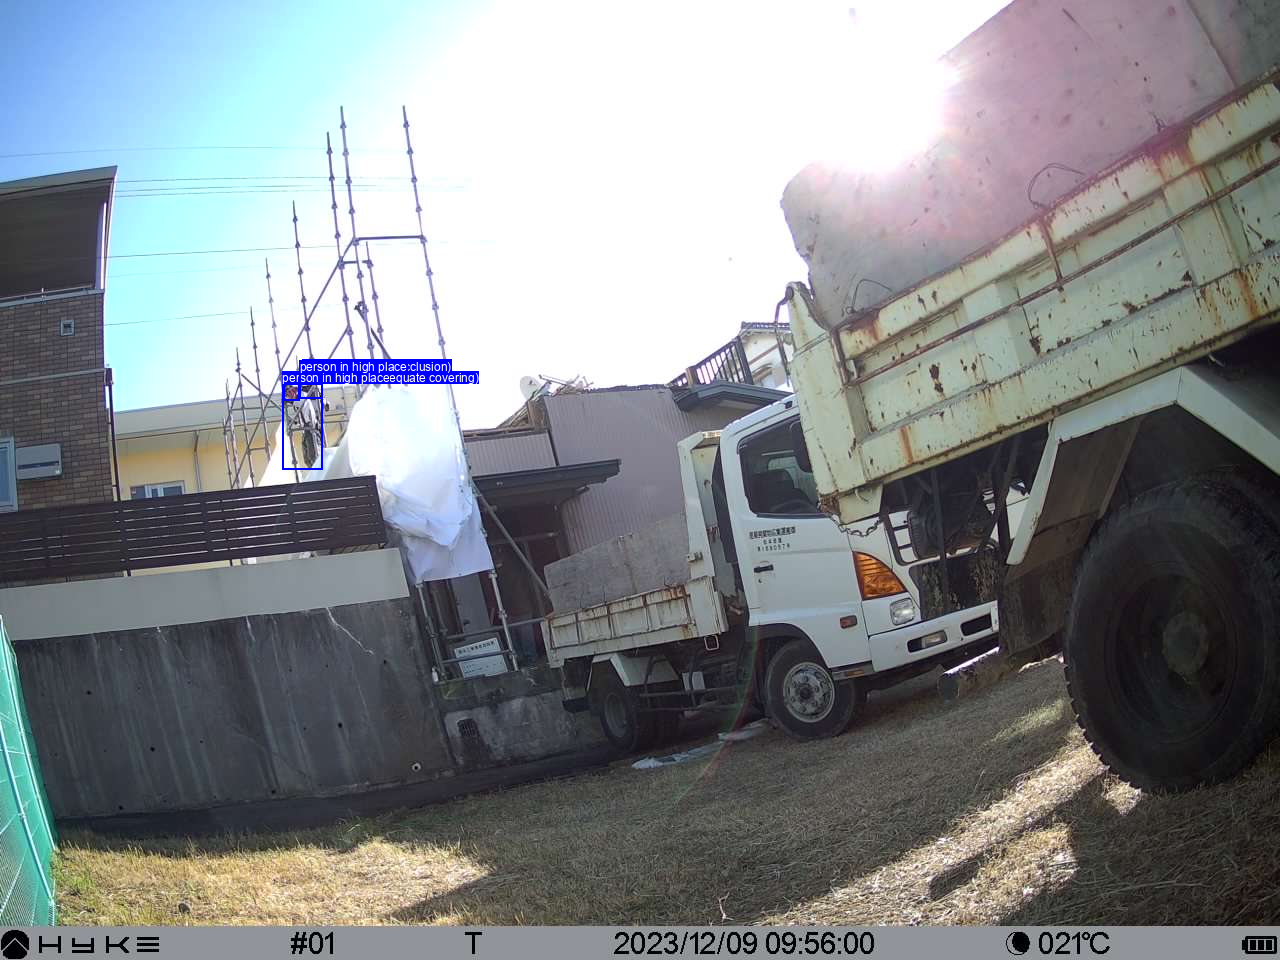

In [14]:
idx = 2
unique_key = eval_annotation_head_add_pred_df[
    eval_annotation_head_add_pred_df['TP'] == 0].iloc[idx, 0]
relative_img_path = eval_annotation_head_add_pred_df[
    eval_annotation_head_add_pred_df['TP'] == 0].iloc[idx, 1]
img_path = f'{root_dir}/data/images/{relative_img_path}'

anno_head = eval_annotation_head_add_pred_df[
    eval_annotation_head_add_pred_df['unique_key'] == unique_key].loc[:, ['label', 'left', 'top', 'right', 'bottom']].values
anno_person = eval_annotation_person_add_pred_df[
    eval_annotation_person_add_pred_df['unique_key'] == unique_key].loc[:, ['label', 'left', 'top', 'right', 'bottom']].values
annotations = np.concatenate([anno_head, anno_person])

pred_head = eval_person_head_detection_head_add_pred_df[
    eval_person_head_detection_head_add_pred_df['unique_key'] == unique_key].loc[:, ['pred', 'left', 'top', 'right', 'bottom']].values
pred_person = eval_person_head_detection_person_add_pred_df[
    eval_person_head_detection_person_add_pred_df['unique_key'] == unique_key].loc[:, ['pred', 'left', 'top', 'right', 'bottom']].values
predictions = np.concatenate([pred_head, pred_person])

font_size = 1.2 * ImageFont.load_default().size
font = ImageFont.truetype("arial.ttf", size=font_size)

image = Image.open(img_path)
draw = ImageDraw.Draw(image)

for pred in annotations:
    label_name = pred[0]
    bbox = [(pred[1], pred[2]), (pred[3], pred[4])]

    # バウンディングボックスの描画
    draw.rectangle(bbox, outline='blue', width=2)

    text_height_head = font.size
    text_width_head = font.getlength(label_name)

    draw.rectangle([(bbox[0][0], bbox[0][1] - text_height_head), (bbox[0][0] + text_width_head, bbox[0][1])], fill='blue')
    draw.text((bbox[0][0], bbox[0][1] - text_height_head), label_name, fill='white', font=font)

for pred in predictions:
    label_name = pred[0]
    bbox = [(pred[1], pred[2]), (pred[3], pred[4])]

    # バウンディングボックスの描画
    draw.rectangle(bbox, outline='red', width=2)

    text_height_head = font.size
    text_width_head = font.getlength(label_name)

    draw.rectangle([(bbox[0][0], bbox[0][1] - text_height_head), (bbox[0][0] + text_width_head, bbox[0][1])], fill='red')
    draw.text((bbox[0][0], bbox[0][1] - text_height_head), label_name, fill='white', font=font)
image